# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/installation.md) before you start.

# Imports

In [33]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

## Env setup

In [34]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
>Here are the imports from the object detection module.

In [35]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [36]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [37]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [38]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [39]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [40]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(2, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

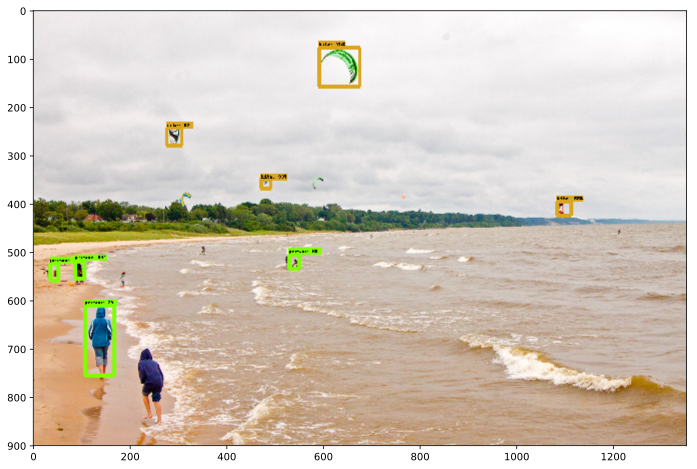

In [12]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

# Video

What's shown above is the tutorial on SSD. What we need to know is basically, `boxes`, `scores`, `classes` and `num_detections`. Let's define a function that outputs those.

In [41]:
def getParams(image_np):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
    return (boxes, scores, classes, num_detections)

In [42]:
import skvideo.io

In [43]:
import skvideo.datasets

In [44]:
video = skvideo.datasets.bigbuckbunny()

In [45]:
def getFrame(video,n):
    """
        returns the n th frame of the video
        this is slow.
        Only use for debugging
    """
    reader = skvideo.io.FFmpegReader(video)
    frameCountError(reader,n)
    counter = 1
    for frame in reader.nextFrame():
        if counter == n:
            reader.close()
            return frame
        counter+=1

In [46]:
def frameCountError(reader,n):
    # get total number of frames in the video
    T = reader.getShape()[0]
    # give error if n>T
    if n>T:
        reader.close()
        raise ValueError("n should be less than or equal to %i, the total number frames in the video"%T)

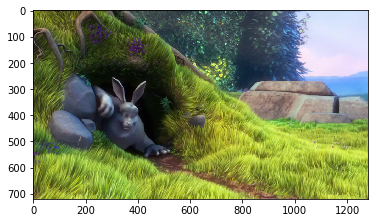

In [47]:
frame1 = getFrame(video,1)
plt.imshow(frame1)
plt.show()

Let's visualize what would happen to this.

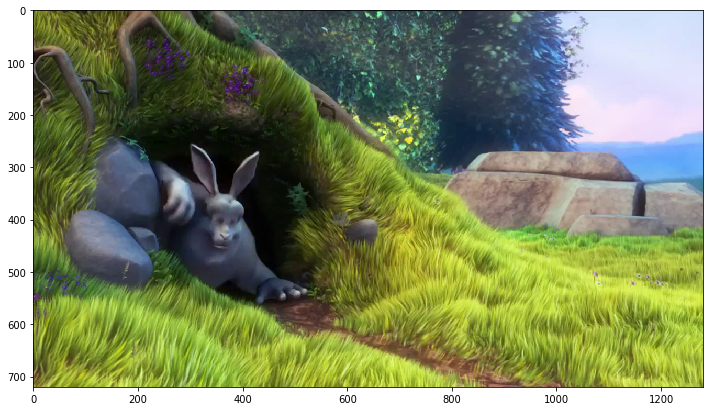

In [52]:
with tf.device('/cpu:0'):
    with tf.Session(graph=detection_graph) as sess:
        b,s,c,n=getParams(frame1)
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
          frame1,
          np.squeeze(b),
          np.squeeze(c).astype(np.int32),
          np.squeeze(s),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(frame1)
        plt.show()

In [53]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [ ]:
adPath = "/media/amila/prank/Ads/seperate trims/"
ads = [adPath+"ADD_%i.mp4"%i for i in range(1,9,1)]            # ads small size
path = '/media/amila/prank/GitHub/videoRecog/videoRecog/videoRecog/'
g_ads = [path+"g_ad_%i.mp4"%i for i in range(1,9,1)]                # Gamma-corrected ads

vidPath = "/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/"
vids = [vidPath+"ad%i.mp4"%i for i in range(1,9,1)]            # ads original size
nVids = [path+"nVid%i.mp4"%i for i in range(1,9,1)]                 # sigma = 5
nVids2 = [path+"nVid2_%i.mp4"%i for i in range(1,9,1)]              # sigma = 20
nVids3 = [path+"nVids3_%i.mp4"%i for i in range(1,9,1)]             # sigma = 1

Visually see for `ads[2]` and `g_ads[2]`

In [ ]:
c = b.squeeze()
c[1]

In [ ]:
frame1=getFrame(vids[2],300)
b,s,c,n=getParams(frame1)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  frame1,
  np.squeeze(b),
  np.squeeze(c).astype(np.int32),
  np.squeeze(s),
  category_index,
  use_normalized_coordinates=True,
  min_score_thresh=.88,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(frame1)
plt.show()

Top 5 contents and their loations:

In [ ]:
print np.squeeze(c)[:5]
print np.squeeze(b)[:5]
print np.squeeze(s)[:5]

In [ ]:
def showDetection(vid,n):
    frame1=getFrame(vid,n)
    b,s,c,n=getParams(frame1)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      frame1,
      np.squeeze(b),
      np.squeeze(c).astype(np.int32),
      np.squeeze(s),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(frame1)
    plt.show()

In [ ]:
%%timeit
with tf.device('/cpu:0'):
    showDetection(vids[2],1)

#  Hash

In [ ]:
def genHash(frame):
    """This function generates the hash for the given frame"""
    global sess
    hash_ = []
    with tf.Session(graph=detection_graph) as sess:
        b,s,c,n=getParams(frame)
    # get the index marker for objects with score>0.5
        marker = 0
        b = b.squeeze()
        s = s.squeeze()
        c = c.squeeze()
        while marker<5:
            if s[marker]>0.5:
                x1,y1,x2,y2 = b[marker]
                cx,cy = (x1+x2)/2,(y1+y2)/2
                hash_.append((c[marker],cx,cy,s[marker]))
            else:
                hash_.append(None)
            marker += 1
    return hash_

In [ ]:
def genHash2(frame):
    """This function generates the hash for the given frame"""
    global sess
    hash_ = []
    with tf.Session(graph=detection_graph) as sess:
        b,s,c,n=getParams(frame)
    # get the index marker for objects with score>0.5
        marker = 0
        b = b.squeeze()
        s = s.squeeze()
        c = c.squeeze()
        while marker<5:
            x1,y1,x2,y2 = b[marker]
            cx,cy = (x1+x2)/2,(y1+y2)/2
            hash_.append((c[marker],cx,cy,s[marker]))
            
            marker += 1
    return hash_

In [ ]:
def saveHash(vid,fileName,n,hashGenFunc):
    """saves the hash of the frames of vid to fileName
    """
    reader = skvideo.io.FFmpegReader(vid)
    frameCountError(reader,n+1)
    toWrite = []
    for i in range(n):
        toWrite.append(hashGenFunc(reader._readFrame()))
    reader.close()
    np.save(fileName,np.array(toWrite))

saving hash

In [45]:
for i in range(8):
    saveHash(vids[i],'vids_%i_genHash1.npy'%i,25,genHash)

KeyboardInterrupt: 

In [124]:
for i in range(8):
    saveHash(vids[i],'vids_%i_genHash2.npy'%i,25,genHash2)

In [125]:
for i in range(8):
    saveHash(nVids[i],'nvids_%i_genHash2.npy'%i,25,genHash2)

In [126]:
for i in range(8):
    saveHash(nVids2[i],'nvids2_%i_genHash2.npy'%i,25,genHash2)

In [127]:
for i in range(8):
    saveHash(nVids3[i],'nvids3_%i_genHash2.npy'%i,25,genHash2)

In [128]:
for i in range(8):
    saveHash(ads[i],'ads_%i_genHash2.npy'%i,25,genHash2)

In [129]:
for i in range(8):
    saveHash(g_ads[i],'g_adds_%i_genHash2.npy'%i,25,genHash2)

In [ ]:
np.load('vids_3_genHash2.npy')

In [1]:
import numpy as np

In [3]:
import sys
sys.path.append('..')

In [5]:

a = np.load('ads_1_genHash2.npy')
b = np.load('ads_2_genHash2.npy')
np.sum(a-b)

5222.6443170793355

In [1]:
%matplotlib inline

In [ ]:

import pandas as pd
from scipy import stats, integrate

In [2]:

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns


In [ ]:
sns.set(color_codes=True)

In [4]:
np.random.seed(sum(map(ord, "distributions")))

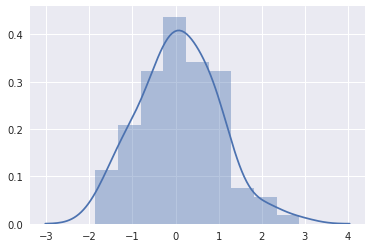

In [5]:
x = np.random.normal(size=100)
sns.distplot(x);

In [4]:
S = np.load('ads_7_genHash2.npy')[:,:,3]

In [5]:
S = S.reshape((1,125))

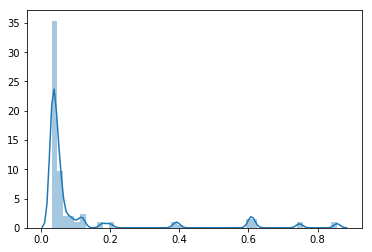

In [6]:
sns.distplot(S)
plt.show()

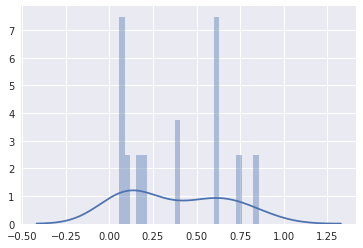

In [29]:
sns.distplot(S,bins=25)
plt.show()

In [4]:
drive   = "/media/amila/prank/"
vidPath = drive+"Users/ASUS/Documents/Adobe/Premiere Pro/9.0/"
vids   = [vidPath+"ad%i.mp4"%i for i in range(1,9,1)] 

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

x264 [error]: main profile doesn't support lossless
[libx264 @ 0x1926d60] Error setting profile main.
[libx264 @ 0x1926d60] Possible profiles: baseline main high high10 high422 high444
Output #0, mp4, to '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0//lowqlty/0/ad3.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    Stream #0:0(eng): Video: h264, none, q=2-31, 128 kb/s, SAR 787:720 DAR 0:0, 25 fps (default)
    Metadata:
      creation_time   : 2017-07-22 09:33:36
      handler_name    : Alias Data Handler
      encoder         : Lavc56.60.100 libx264
    Stream #0:1(eng): Audio: aac, 48000 Hz, stereo, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:33:36
      handler_name    : Alias Data Handler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (native) -> h264 (libx264))
  Stream #0:1 -> #0:1 (copy)
Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, r

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad6.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:34:02
  Duration: 00:00:30.04, start: 0.000000, bitrate: 9697 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 9384 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:34:02
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:34:02
      handler_name    : Alias Data Handler
x264 [error]: main profile doesn't support lossless
[libx264 @ 0x8c1c00] Error setting profile main.
[libx264 @ 0x8c1c00] Possible profiles: baseline ma

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

frame=  750 fps=191 q=-1.0 Lsize=    4363kB time=00:00:30.03 bitrate=1189.8kbits/s    
video:3175kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.542885%
[libx264 @ 0x22047e0] frame I:9     Avg QP:15.17  size: 34365
[libx264 @ 0x22047e0] frame P:249   Avg QP:18.90  size:  8274
[libx264 @ 0x22047e0] frame B:492   Avg QP:21.39  size:  1791
[libx264 @ 0x22047e0] consecutive B-frames:  7.1% 12.3% 12.4% 68.3%
[libx264 @ 0x22047e0] mb I  I16..4: 31.8%  0.0% 68.2%
[libx264 @ 0x22047e0] mb P  I16..4:  8.3%  0.0%  6.3%  P16..4: 24.9% 11.8%  4.5%  0.0%  0.0%    skip:44.1%
[libx264 @ 0x22047e0] mb B  I16..4:  0.9%  0.0%  0.3%  B16..8: 12.7%  4.1%  0.6%  direct: 6.3%  skip:75.2%  L0:34.5% L1:43.4% BI:22.0%
[libx264 @ 0x22047e0] coded y,uvDC,uvAC intra: 48.6% 58.4% 18.3% inter: 7.2% 11.1% 0.3%
[libx264 @ 0x22047e0] i16 v,h,dc,p: 51% 28% 11% 10%
[libx264 @ 0x22047e0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 31% 26% 15%  5%  5%  5%  5%  5%  4%
[libx264 @ 0x22047e0] i8c dc,h,

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:22:07
  Duration: 00:00:09.96, start: 0.000000, bitrate: 3877 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 3562 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
[libx264 @ 0x24cd420] using SAR=787/720
[libx264 @ 0x24cd420] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0x2

frame=  750 fps=226 q=-1.0 Lsize=    3027kB time=00:00:30.03 bitrate= 825.5kbits/s    
video:1840kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.784691%
[libx264 @ 0x25e0760] frame I:4     Avg QP:13.81  size: 25919
[libx264 @ 0x25e0760] frame P:204   Avg QP:16.85  size:  6187
[libx264 @ 0x25e0760] frame B:542   Avg QP:21.53  size:   955
[libx264 @ 0x25e0760] consecutive B-frames:  3.1%  0.5%  3.6% 92.8%
[libx264 @ 0x25e0760] mb I  I16..4: 56.6%  0.0% 43.4%
[libx264 @ 0x25e0760] mb P  I16..4:  4.1%  0.0%  1.8%  P16..4: 18.8%  7.8%  4.3%  0.0%  0.0%    skip:63.2%
[libx264 @ 0x25e0760] mb B  I16..4:  0.2%  0.0%  0.1%  B16..8:  5.3%  2.2%  0.4%  direct: 3.0%  skip:88.7%  L0:26.9% L1:39.9% BI:33.1%
[libx264 @ 0x25e0760] coded y,uvDC,uvAC intra: 42.2% 51.7% 24.4% inter: 5.0% 4.4% 0.2%
[libx264 @ 0x25e0760] i16 v,h,dc,p: 56% 32%  7%  5%
[libx264 @ 0x25e0760] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 34% 28% 16%  3%  3%  4%  4%  4%  4%
[libx264 @ 0x25e0760] i8c dc,h,v

frame=  875 fps=219 q=-1.0 Lsize=    4118kB time=00:00:35.05 bitrate= 962.4kbits/s    
video:2733kB audio:1358kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.658297%
[libx264 @ 0x1755ce0] frame I:8     Avg QP:11.72  size: 28917
[libx264 @ 0x1755ce0] frame P:315   Avg QP:16.54  size:  6364
[libx264 @ 0x1755ce0] frame B:552   Avg QP:19.12  size:  1018
[libx264 @ 0x1755ce0] consecutive B-frames: 11.9%  9.6%  7.2% 71.3%
[libx264 @ 0x1755ce0] mb I  I16..4: 61.2%  0.0% 38.8%
[libx264 @ 0x1755ce0] mb P  I16..4: 12.9%  0.0%  3.7%  P16..4: 15.7%  6.7%  3.0%  0.0%  0.0%    skip:58.0%
[libx264 @ 0x1755ce0] mb B  I16..4:  0.5%  0.0%  0.1%  B16..8:  7.2%  2.2%  0.3%  direct: 4.7%  skip:85.1%  L0:33.5% L1:43.2% BI:23.3%
[libx264 @ 0x1755ce0] coded y,uvDC,uvAC intra: 30.3% 43.2% 14.2% inter: 5.3% 7.8% 0.3%
[libx264 @ 0x1755ce0] i16 v,h,dc,p: 67% 19%  9%  5%
[libx264 @ 0x1755ce0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 34% 20% 18%  4%  5%  6%  5%  5%  4%
[libx264 @ 0x1755ce0] i8c dc,h,v

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad1.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:21:31
  Duration: 00:00:40.68, start: 0.000000, bitrate: 10507 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 10195 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:21:31
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:21:31
      handler_name    : Alias Data Handler
[libx264 @ 0x15d8a20] using SAR=787/720
[libx264 @ 0x15d8a20] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0

frame=  750 fps=199 q=-1.0 Lsize=    2177kB time=00:00:30.03 bitrate= 593.7kbits/s    
video:990kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.093944%
[libx264 @ 0x15857e0] frame I:9     Avg QP:24.85  size: 14533
[libx264 @ 0x15857e0] frame P:249   Avg QP:30.20  size:  2581
[libx264 @ 0x15857e0] frame B:492   Avg QP:32.29  size:   486
[libx264 @ 0x15857e0] consecutive B-frames:  7.1% 12.3% 12.4% 68.3%
[libx264 @ 0x15857e0] mb I  I16..4: 58.0%  0.0% 42.0%
[libx264 @ 0x15857e0] mb P  I16..4: 11.5%  0.0%  2.3%  P16..4: 13.2%  5.0%  0.9%  0.0%  0.0%    skip:67.2%
[libx264 @ 0x15857e0] mb B  I16..4:  1.0%  0.0%  0.0%  B16..8:  5.8%  1.5%  0.1%  direct: 0.9%  skip:90.6%  L0:37.9% L1:51.7% BI:10.3%
[libx264 @ 0x15857e0] coded y,uvDC,uvAC intra: 22.0% 27.0% 2.7% inter: 1.5% 1.5% 0.0%
[libx264 @ 0x15857e0] i16 v,h,dc,p: 36% 31% 17% 16%
[libx264 @ 0x15857e0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 26% 24% 24%  5%  5%  5%  5%  4%  4%
[libx264 @ 0x15857e0] i8c dc,h,v,p

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:22:07
  Duration: 00:00:09.96, start: 0.000000, bitrate: 3877 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 3562 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
[libx264 @ 0x2167420] using SAR=787/720
[libx264 @ 0x2167420] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0x2

frame=  750 fps=257 q=-1.0 Lsize=    1658kB time=00:00:30.03 bitrate= 452.1kbits/s    
video:471kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.442049%
[libx264 @ 0x11d6760] frame I:4     Avg QP:23.25  size:  9939
[libx264 @ 0x11d6760] frame P:204   Avg QP:29.73  size:  1534
[libx264 @ 0x11d6760] frame B:542   Avg QP:31.70  size:   237
[libx264 @ 0x11d6760] consecutive B-frames:  3.1%  0.5%  3.6% 92.8%
[libx264 @ 0x11d6760] mb I  I16..4: 78.1%  0.0% 21.9%
[libx264 @ 0x11d6760] mb P  I16..4:  4.0%  0.0%  0.8%  P16..4:  9.4%  4.0%  1.0%  0.0%  0.0%    skip:80.9%
[libx264 @ 0x11d6760] mb B  I16..4:  0.2%  0.0%  0.0%  B16..8:  2.4%  0.9%  0.1%  direct: 0.4%  skip:96.1%  L0:34.9% L1:47.9% BI:17.2%
[libx264 @ 0x11d6760] coded y,uvDC,uvAC intra: 23.9% 22.9% 4.0% inter: 0.9% 0.5% 0.0%
[libx264 @ 0x11d6760] i16 v,h,dc,p: 43% 34% 14% 10%
[libx264 @ 0x11d6760] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 31% 24% 23%  4%  3%  4%  4%  4%  3%
[libx264 @ 0x11d6760] i8c dc,h,v,p

[libx264 @ 0x2519ce0] profile Main, level 3.0
[libx264 @ 0x2519ce0] 264 - core 148 r2643 5c65704 - H.264/MPEG-4 AVC codec - Copyleft 2003-2015 - http://www.videolan.org/x264.html - options: cabac=0 ref=1 deblock=0:0:0 analyse=0x1:0x111 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=6 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=0 open_gop=0 weightp=0 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=30.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
[mp4 @ 0x2519060] Codec for stream 1 does not use global headers but container format requires global headers
Output #0, mp4, to '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0//lowqlty/30/ad7.mp4':
  Metadata:
    major_brand     : mp42
    minor_versio

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

frame=  750 fps=218 q=-1.0 Lsize=    1550kB time=00:00:30.03 bitrate= 422.6kbits/s    
video:362kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.543559%
[libx264 @ 0x1f377e0] frame I:9     Avg QP:34.67  size:  6263
[libx264 @ 0x1f377e0] frame P:249   Avg QP:40.71  size:   986
[libx264 @ 0x1f377e0] frame B:492   Avg QP:41.10  size:   140
[libx264 @ 0x1f377e0] consecutive B-frames:  7.1% 12.3% 12.4% 68.3%
[libx264 @ 0x1f377e0] mb I  I16..4: 87.5%  0.0% 12.5%
[libx264 @ 0x1f377e0] mb P  I16..4: 13.9%  0.0%  0.2%  P16..4:  6.0%  1.2%  0.1%  0.0%  0.0%    skip:78.5%
[libx264 @ 0x1f377e0] mb B  I16..4:  0.6%  0.0%  0.0%  B16..8:  1.9%  0.3%  0.0%  direct: 0.3%  skip:96.8%  L0:42.4% L1:55.9% BI: 1.6%
[libx264 @ 0x1f377e0] coded y,uvDC,uvAC intra: 5.7% 18.2% 1.0% inter: 0.2% 0.6% 0.0%
[libx264 @ 0x1f377e0] i16 v,h,dc,p: 41% 30% 15% 13%
[libx264 @ 0x1f377e0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 19% 23% 35%  5%  4%  3%  4%  3%  4%
[libx264 @ 0x1f377e0] i8c dc,h,v,p:

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:22:07
  Duration: 00:00:09.96, start: 0.000000, bitrate: 3877 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 3562 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
[libx264 @ 0x19bb420] using SAR=787/720
[libx264 @ 0x19bb420] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0x1

frame=  750 fps=287 q=-1.0 Lsize=    1342kB time=00:00:30.03 bitrate= 365.9kbits/s    
video:155kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.787863%
[libx264 @ 0x224c760] frame I:4     Avg QP:32.62  size:  4459
[libx264 @ 0x224c760] frame P:204   Avg QP:39.64  size:   505
[libx264 @ 0x224c760] frame B:542   Avg QP:39.68  size:    68
[libx264 @ 0x224c760] consecutive B-frames:  3.1%  0.5%  3.6% 92.8%
[libx264 @ 0x224c760] mb I  I16..4: 91.9%  0.0%  8.1%
[libx264 @ 0x224c760] mb P  I16..4:  4.3%  0.0%  0.1%  P16..4:  4.3%  1.2%  0.1%  0.0%  0.0%    skip:90.0%
[libx264 @ 0x224c760] mb B  I16..4:  0.2%  0.0%  0.0%  B16..8:  0.8%  0.2%  0.0%  direct: 0.1%  skip:98.7%  L0:43.2% L1:54.2% BI: 2.5%
[libx264 @ 0x224c760] coded y,uvDC,uvAC intra: 9.2% 16.6% 1.9% inter: 0.1% 0.2% 0.0%
[libx264 @ 0x224c760] i16 v,h,dc,p: 47% 32% 14%  8%
[libx264 @ 0x224c760] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 27% 20% 34%  4%  3%  4%  3%  4%  3%
[libx264 @ 0x224c760] i8c dc,h,v,p:

[libx264 @ 0x2312ce0] 264 - core 148 r2643 5c65704 - H.264/MPEG-4 AVC codec - Copyleft 2003-2015 - http://www.videolan.org/x264.html - options: cabac=0 ref=1 deblock=0:0:0 analyse=0x1:0x111 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=6 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=0 open_gop=0 weightp=0 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=40.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
[mp4 @ 0x2312060] Codec for stream 1 does not use global headers but container format requires global headers
Output #0, mp4, to '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0//lowqlty/40/ad7.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    en

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

frame=  750 fps=226 q=-1.0 Lsize=    1361kB time=00:00:30.03 bitrate= 371.1kbits/s    
video:173kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.761862%
[libx264 @ 0xc767e0] frame I:9     Avg QP:44.86  size:  2660
[libx264 @ 0xc767e0] frame P:249   Avg QP:49.86  size:   468
[libx264 @ 0xc767e0] frame B:492   Avg QP:49.97  size:    74
[libx264 @ 0xc767e0] consecutive B-frames:  7.1% 12.3% 12.4% 68.3%
[libx264 @ 0xc767e0] mb I  I16..4: 99.1%  0.0%  0.9%
[libx264 @ 0xc767e0] mb P  I16..4:  9.8%  0.0%  0.0%  P16..4:  2.6%  0.3%  0.0%  0.0%  0.0%    skip:87.2%
[libx264 @ 0xc767e0] mb B  I16..4:  0.2%  0.0%  0.0%  B16..8:  0.8%  0.0%  0.0%  direct: 0.3%  skip:98.7%  L0:44.1% L1:55.5% BI: 0.4%
[libx264 @ 0xc767e0] coded y,uvDC,uvAC intra: 1.4% 22.3% 0.5% inter: 0.1% 0.4% 0.0%
[libx264 @ 0xc767e0] i16 v,h,dc,p: 53% 29% 12%  5%
[libx264 @ 0xc767e0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 19% 19% 52%  2%  2%  1%  2%  1%  3%
[libx264 @ 0xc767e0] i8c dc,h,v,p: 96%  3%  1

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:22:07
  Duration: 00:00:09.96, start: 0.000000, bitrate: 3877 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 3562 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
[libx264 @ 0x999420] using SAR=787/720
[libx264 @ 0x999420] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0x999

frame=  750 fps=282 q=-1.0 Lsize=    1268kB time=00:00:30.03 bitrate= 345.9kbits/s    
video:81kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.893715%
[libx264 @ 0x1315760] frame I:4     Avg QP:42.95  size:  2404
[libx264 @ 0x1315760] frame P:204   Avg QP:49.11  size:   228
[libx264 @ 0x1315760] frame B:542   Avg QP:49.61  size:    48
[libx264 @ 0x1315760] consecutive B-frames:  3.1%  0.5%  3.6% 92.8%
[libx264 @ 0x1315760] mb I  I16..4: 99.0%  0.0%  1.0%
[libx264 @ 0x1315760] mb P  I16..4:  3.1%  0.0%  0.0%  P16..4:  1.7%  0.3%  0.0%  0.0%  0.0%    skip:94.9%
[libx264 @ 0x1315760] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  0.5%  0.0%  0.0%  direct: 0.2%  skip:99.2%  L0:44.2% L1:55.1% BI: 0.7%
[libx264 @ 0x1315760] coded y,uvDC,uvAC intra: 3.0% 20.0% 0.4% inter: 0.1% 0.1% 0.0%
[libx264 @ 0x1315760] i16 v,h,dc,p: 57% 29% 11%  3%
[libx264 @ 0x1315760] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 22% 22% 43%  4%  2%  2%  2%  2%  2%
[libx264 @ 0x1315760] i8c dc,h,v,p: 

[libx264 @ 0x1728ce0] profile Main, level 3.0
[libx264 @ 0x1728ce0] 264 - core 148 r2643 5c65704 - H.264/MPEG-4 AVC codec - Copyleft 2003-2015 - http://www.videolan.org/x264.html - options: cabac=0 ref=1 deblock=0:0:0 analyse=0x1:0x111 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=6 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=0 open_gop=0 weightp=0 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=50.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
[mp4 @ 0x1728060] Codec for stream 1 does not use global headers but container format requires global headers
Output #0, mp4, to '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0//lowqlty/50/ad7.mp4':
  Metadata:
    major_brand     : mp42
    minor_versio

ffmpeg version 2.8.11-0ubuntu0.16.04.1 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.4.0 (Ubuntu 5.4.0-6ubuntu1~16.04.4) 20160609
  configuration: --prefix=/usr --extra-version=0ubuntu0.16.04.1 --build-suffix=-ffmpeg --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --cc=cc --cxx=g++ --enable-gpl --enable-shared --disable-stripping --disable-decoder=libopenjpeg --disable-decoder=libschroedinger --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librtmp --enable-libschroedinger --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --e

frame=  750 fps=231 q=-1.0 Lsize=    1355kB time=00:00:30.03 bitrate= 369.5kbits/s    
video:168kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.769543%
[libx264 @ 0x112f7e0] frame I:9     Avg QP:46.14  size:  2523
[libx264 @ 0x112f7e0] frame P:249   Avg QP:50.44  size:   448
[libx264 @ 0x112f7e0] frame B:492   Avg QP:50.43  size:    74
[libx264 @ 0x112f7e0] consecutive B-frames:  7.1% 12.3% 12.4% 68.3%
[libx264 @ 0x112f7e0] mb I  I16..4: 99.3%  0.0%  0.7%
[libx264 @ 0x112f7e0] mb P  I16..4:  9.3%  0.0%  0.0%  P16..4:  2.6%  0.3%  0.0%  0.0%  0.0%    skip:87.8%
[libx264 @ 0x112f7e0] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  0.8%  0.0%  0.0%  direct: 0.3%  skip:98.7%  L0:44.2% L1:55.5% BI: 0.3%
[libx264 @ 0x112f7e0] coded y,uvDC,uvAC intra: 1.3% 23.0% 0.4% inter: 0.1% 0.3% 0.0%
[libx264 @ 0x112f7e0] i16 v,h,dc,p: 55% 29% 12%  5%
[libx264 @ 0x112f7e0] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 18% 19% 53%  2%  2%  1%  2%  1%  3%
[libx264 @ 0x112f7e0] i8c dc,h,v,p:

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/ad4.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    creation_time   : 2017-07-22 09:22:07
  Duration: 00:00:09.96, start: 0.000000, bitrate: 3877 kb/s
    Stream #0:0(eng): Video: h264 (Main) (avc1 / 0x31637661), yuv420p(tv, bt470bg), 720x576 [SAR 128:117 DAR 160:117], 3562 kb/s, SAR 787:720 DAR 787:576, 25 fps, 25 tbr, 25k tbn, 50 tbc (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
      encoder         : AVC Coding
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 317 kb/s (default)
    Metadata:
      creation_time   : 2017-07-22 09:22:07
      handler_name    : Alias Data Handler
[libx264 @ 0x1e4e420] using SAR=787/720
[libx264 @ 0x1e4e420] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 AVX2 LZCNT BMI2
[libx264 @ 0x1

frame=  750 fps=293 q=-1.0 Lsize=    1267kB time=00:00:30.03 bitrate= 345.5kbits/s    
video:79kB audio:1164kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.895869%
[libx264 @ 0xfe1760] frame I:4     Avg QP:44.37  size:  2332
[libx264 @ 0xfe1760] frame P:204   Avg QP:49.86  size:   222
[libx264 @ 0xfe1760] frame B:542   Avg QP:50.22  size:    48
[libx264 @ 0xfe1760] consecutive B-frames:  3.1%  0.5%  3.6% 92.8%
[libx264 @ 0xfe1760] mb I  I16..4: 99.0%  0.0%  1.0%
[libx264 @ 0xfe1760] mb P  I16..4:  2.9%  0.0%  0.0%  P16..4:  1.7%  0.3%  0.0%  0.0%  0.0%    skip:95.1%
[libx264 @ 0xfe1760] mb B  I16..4:  0.1%  0.0%  0.0%  B16..8:  0.5%  0.0%  0.0%  direct: 0.2%  skip:99.2%  L0:45.3% L1:54.2% BI: 0.5%
[libx264 @ 0xfe1760] coded y,uvDC,uvAC intra: 3.2% 20.1% 0.2% inter: 0.1% 0.1% 0.0%
[libx264 @ 0xfe1760] i16 v,h,dc,p: 58% 28% 11%  3%
[libx264 @ 0xfe1760] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 19% 23% 46%  5%  1%  2%  2%  2%  2%
[libx264 @ 0xfe1760] i8c dc,h,v,p: 95%  3%  2%

[libx264 @ 0x2386ce0] 264 - core 148 r2643 5c65704 - H.264/MPEG-4 AVC codec - Copyleft 2003-2015 - http://www.videolan.org/x264.html - options: cabac=0 ref=1 deblock=0:0:0 analyse=0x1:0x111 me=hex subme=2 psy=1 psy_rd=1.00:0.00 mixed_ref=0 me_range=16 chroma_me=1 trellis=0 8x8dct=0 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=0 threads=6 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=0 open_gop=0 weightp=0 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=10 rc=crf mbtree=1 crf=51.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
[mp4 @ 0x2386060] Codec for stream 1 does not use global headers but container format requires global headers
Output #0, mp4, to '/media/amila/prank/Users/ASUS/Documents/Adobe/Premiere Pro/9.0//lowqlty/60/ad7.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 0
    compatible_brands: mp42mp41
    en

In [10]:
import numpy as np

In [11]:
np.load('hashes/lowqlty/10/ad1.npy')

array([[[  6.70000000e+01,   5.55144310e-01,   4.95995462e-01,
           4.34740245e-01],
        [  1.00000000e+00,   3.74267697e-01,   1.63190410e-01,
           1.23232737e-01],
        [  4.90000000e+01,   4.78457719e-01,   5.67501366e-01,
           1.08791739e-01],
        [  8.80000000e+01,   2.62197852e-01,   8.07365954e-01,
           1.04828648e-01],
        [  4.90000000e+01,   4.52920884e-01,   5.03635108e-01,
           9.81628746e-02]],

       [[  1.00000000e+00,   3.51009011e-01,   2.32811630e-01,
           5.12105703e-01],
        [  1.00000000e+00,   3.57642412e-01,   8.07776332e-01,
           2.74378657e-01],
        [  1.00000000e+00,   3.48052561e-01,   1.65407851e-01,
           1.85261190e-01],
        [  1.00000000e+00,   2.05779761e-01,   5.06961048e-01,
           1.62676841e-01],
        [  1.00000000e+00,   3.48221242e-01,   5.19434869e-01,
           1.62357509e-01]],

       [[  1.00000000e+00,   3.51272345e-01,   2.33002305e-01,
           4.96387899e-